# クラス分類学習モデルの作成、予測の実行

In [1]:
import os
import random

# basic DS libraries
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# plot libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from seaborn_analyzer import classplot
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

%matplotlib inline

# プログレスバー
from tqdm import tqdm

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# データセット分割・評価検証
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# config python file
import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

# seedの固定
def fix_seed(seed: int):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)


# 再現性をもたせるためのseed固定
SEED = config.SEED
fix_seed(SEED)

In [2]:
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# 特徴量チェック
def check(df):
    col_list = df.columns.values  # 列名を取得
    row = []
    for col in col_list:
        unique = ""
        value_counts = ""
        if df[col].nunique() < 12:
            unique = df[col].unique()
            value_counts = df[col].value_counts().to_dict()
        tmp = (
            col,  # 列名
            df[col].dtypes,  # データタイプ
            df[col].isnull().sum(),  # null数
            df[col].count(),  # データ数 (欠損値除く)
            df[col].nunique(),  # ユニーク値の数 (欠損値除く)
            unique,  # ユニーク値
            value_counts,  # ユニーク値のそれぞれの個数
        )
        row.append(tmp)  # tmpを順次rowに保存
    df = pd.DataFrame(row)  # rowをデータフレームの形式に変換
    df.columns = [
        "feature",
        "dtypes",
        "nan",
        "count",
        "num_unique",
        "unique",
        "unique_counts",
    ]  # データフレームの列名指定
    # unique_countsの中身確認のために横幅拡張
    d = dict(selector=".col8", props=[("min-width", "200px")])  # name
    # display(df.style.set_table_styles([d]))
    # display(df)
    return df.style.set_table_styles([d])

# 2値分類モデルの作成・実行

2値分類モデルを作成、実行し、クラス分類に有用な特徴量を見つける  
決定木以外にも、基本的な2値分類を実施できるモデルを採用し、各モデル間で比較していく。  
精度は重視しないが、accuracyよりもf1スコアを重視する。  
目的変数に偏りがある（不均衡データ、1（5年後以内に死亡）<0（5年語以内に生存））ので、**サンプリング方法を要検討**

In [3]:
df_MB_encoded = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_DIR + "/df_MB_encoded.pkl"
)
check(df_MB_encoded)

,feature,dtypes,nan,count,num_unique,unique,unique_counts
0,LYMPH_NODES_EXAMINED_POSITIVE,float64,0,1251,27,,
1,NPI,float64,0,1251,208,,
2,CELLULARITY,int64,0,1251,3,[3 2 1],"{3: 615, 2: 500, 1: 136}"
3,CHEMOTHERAPY,int64,0,1251,2,[0 1],"{0: 972, 1: 279}"
4,INFERRED_MENOPAUSAL_STATE,int64,0,1251,2,[0 1],"{1: 952, 0: 299}"
5,AGE_AT_DIAGNOSIS,float64,0,1251,1089,,
6,GRADE,float64,0,1251,3,[3. 2. 1.],"{3.0: 665, 2.0: 492, 1.0: 94}"
7,PR_STATUS,int64,0,1251,2,[1 0],"{1: 659, 0: 592}"
8,TMB_NONSYNONYMOUS,float64,0,1251,29,,
9,ER_IHC,int64,0,1251,2,[1 0],"{1: 969, 0: 282}"


In [4]:
print(
    "データセット全体に占める5年後の死亡者のデータの割合： ",
    df_MB_encoded[df_MB_encoded.target_OS_5years == True].shape[0]
    / df_MB_encoded.shape[0],
)

データセット全体に占める5年後の死亡者のデータの割合：  0.18784972022382093


# 学習データ分割

1. X（説明変数）とy（目的変数）に分割(y=df['target'])
2. train_test_splitによる基本的なデータ分割（train:test=75%:25%）※層化検証など他の分割手法は後で実施  

In [5]:
# Xとyに分割
X = df_MB_encoded.drop("target_OS_5years", axis=1)
y = df_MB_encoded["target_OS_5years"].astype(bool)

In [6]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(y_train.value_counts(), y_test.value_counts())

(938, 53)

(313, 53)

(938,)

(313,)

False    765
True     173
Name: target_OS_5years, dtype: int64

False    251
True      62
Name: target_OS_5years, dtype: int64

# 学習データの分布をプロット

オーバーサンプリング手法がどのように目的変数を生成しているのかを可視化する。  
x,y軸には以下の２パターンを描画する  
1. 3.0.0のノートブックで実施した決定木で重要度の上位に位置した特徴量（["NPI", "THREEGENE_ER-/HER2-"]）
2. float型の特徴量の中で、値がそれなりに分布している特徴量（["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"]）

## ツール
- seaborn-analyzer: https://github.com/c60evaporator/seaborn-analyzer

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def transform_normalization(df: pd.DataFrame):
    # x,y軸の特徴量の標準化
    ss = StandardScaler()
    ss.fit(df)
    df = pd.DataFrame(
        ss.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df


def transform_minmaxscaler(df: pd.DataFrame):
    # x,y軸の特徴量の標準化
    mm = MinMaxScaler()
    mm.fit(df)
    df = pd.DataFrame(
        mm.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df

plotするための関数

In [8]:
plot_columns_1 = ["NPI", "THREEGENE_ER-/HER2-"]  # 3.0.0の決定木モデルで最も重要度の高かった特徴量
plot_columns_2 = ["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"]  # 適当な量的変数の特徴量
plot_columns_3 = ["TUMOR_SIZE", "LYMPH_NODES_EXAMINED_POSITIVE"]  # targetと相関の高い特徴量

In [9]:
def sns_joinplot(
    data: pd.DataFrame,
    plot_columns: list,
    target: str = "target",
    normalization: bool = True,
    save_path: str = None,  # also need a file name
):
    df_tmp = data
    if normalization:
        df_tmp = transform_minmaxscaler(df_tmp)
    sns.jointplot(
        x=plot_columns[0],
        y=plot_columns[1],
        data=df_tmp,
        hue=target,
    )
    plt.plot()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

cv_number=0/10


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,


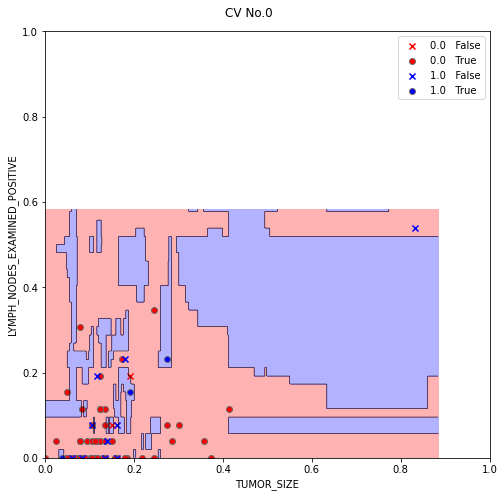

In [11]:
# プロットの共通化のために関数を定義。パラメータの固定が目的
# 範囲は基本[0,1]とし、プロットした際に比較しやすいようにする。
def sns_separator_plot(
    clf,
    x_columns: list,
    y_column: str,
    data: pd.DataFrame,
    normalization: bool = True,
    save_path: str = None,  # also need a file name
):
    df_tmp = data
    if normalization:
        df_tmp = transform_minmaxscaler(data)

    # 散布図のプロット
    """plt.figure(figsize=(8, 8))
    plt.scatter(df_tmp[x_columns[0]], df_tmp[x_columns[1]])
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel(x_columns[0])
    plt.ylabel(x_columns[1])
    plt.plot()
    """
    classplot.class_separator_plot(
        clf=clf,
        x=x_columns,
        y=y_column,
        data=df_tmp,
        # plot_scatter="class_error",
        scatter_colors=["r", "b"],
        cv=10,
        cv_seed=SEED,
        true_marker="o",
        false_marker="x",
        subplot_kws={"figsize": (7, 7)},
    )
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    if save_path:
        plt.savefig(save_path)
    else:
        plt.plot()


# 例

df_tmp = pd.merge(X_train, y_train, left_index=True, right_index=True)

clf = RandomForestClassifier()
sns_separator_plot(
    clf=clf,
    x_columns=plot_columns_3,
    y_column="target_OS_5years",
    data=df_tmp,
)

pass

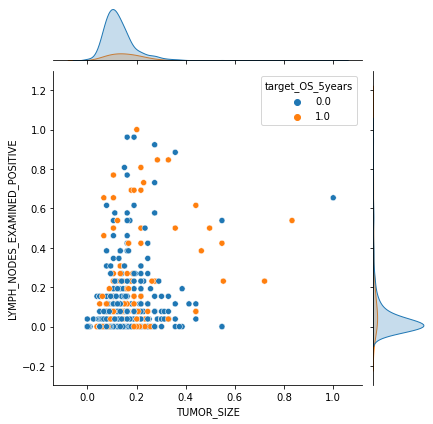

In [14]:
df_tmp = pd.merge(X_train, y_train, left_index=True, right_index=True)

save_path = (
    config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_DIR
    + "/basic_scatter("
    + plot_columns_3[0]
    + " x "
    + plot_columns_3[1]
    + ").png"
)

# plot_columns_3の散布図
sns_joinplot(df_tmp, plot_columns_3, target="target_OS_5years", save_path=save_path)

cv_number=0/10


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,


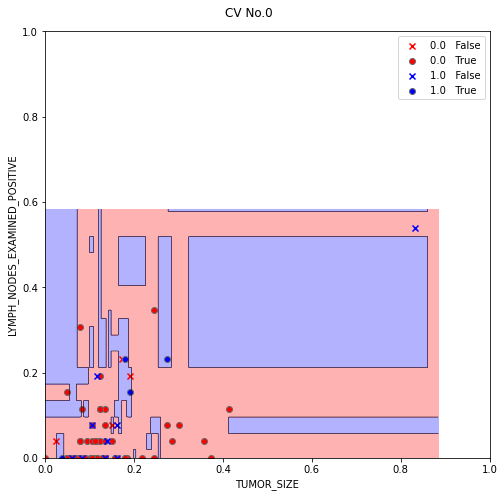

In [15]:
df_tmp = pd.merge(X_train, y_train, left_index=True, right_index=True)

clf = DecisionTreeClassifier()
# plot_columns_1での分類図例
sns_separator_plot(
    clf=clf,
    x_columns=plot_columns_3,
    y_column="target_OS_5years",
    data=df_tmp,
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_DIR
    + "/sample_normal_pc3.png",
)

# SMOTEによるオーバーサンプリング
SMOTEと呼ばれる手法によって、不均衡を低減する  
どのようにオーバーサンプリングするのか要確認

In [16]:
sm = SMOTE(random_state=SEED)

X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
y_resampled.value_counts()

False    765
True     765
Name: target_OS_5years, dtype: int64

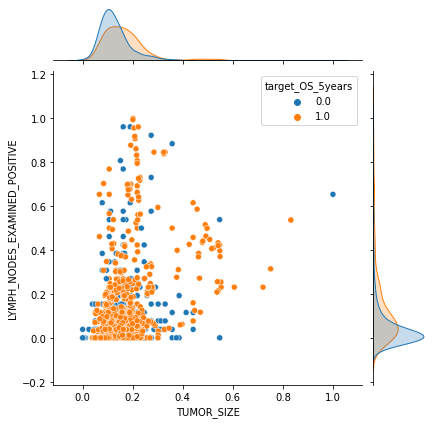

In [17]:
df_tmp = pd.merge(X_resampled, y_resampled, left_index=True, right_index=True)

save_path = (
    config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_SMOTE_DIR
    + "/SMOTE_scatter("
    + plot_columns_3[0]
    + " x "
    + plot_columns_3[1]
    + ").png"
)

sns_joinplot(
    data=df_tmp,
    plot_columns=plot_columns_3,
    target="target_OS_5years",
    save_path=save_path,
)

cv_number=0/10


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,


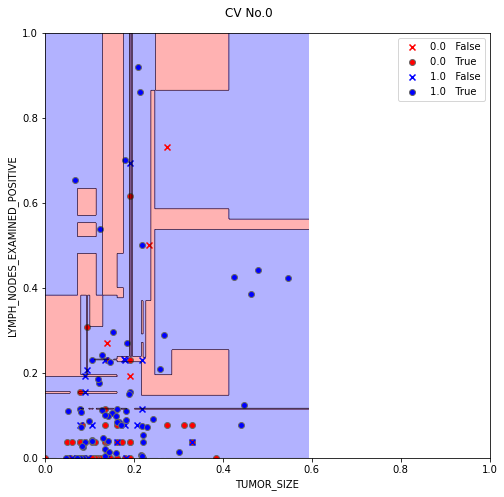

In [18]:
clf = DecisionTreeClassifier()
# 例
sns_separator_plot(
    clf=clf,
    x_columns=plot_columns_3,
    y_column="target_OS_5years",
    data=df_tmp,
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_DIR
    + "/sample_SMOTE_pc3.png",
)

# 2値分類モデル

In [19]:
def show_scores(y_test: pd.Series, y_pred_tree: pd.Series):
    print("accuracy: ", accuracy_score(y_test, y_pred_tree))
    print("precision: ", precision_score(y_test, y_pred_tree))
    print("recall: ", recall_score(y_test, y_pred_tree))
    print("f1 score: ", f1_score(y_test, y_pred_tree))

In [20]:
def show_confusion_matrix(
    y_test: pd.Series,
    y_pred: pd.Series,
    model_name: str = "confusion matrix",
    display_details: bool = False,
):
    cm = confusion_matrix(y_test, y_pred, normalize="all", labels=[True, False])
    df_cm = pd.DataFrame(data=cm, index=[True, False], columns=[True, False])

    fig = plt.figure()
    sns.heatmap(df_cm, square=True, cbar=True, annot=True, cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.plot()

    if display_details:
        tn, fp, fn, tp = cm.ravel()
        print("tn: ", tn, "\nfp: ", fp, "\nfn:", fn, "\ntp:", tp)
        show_scores(y_test, y_pred)

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

False    251
True      62
Name: target_OS_5years, dtype: int64

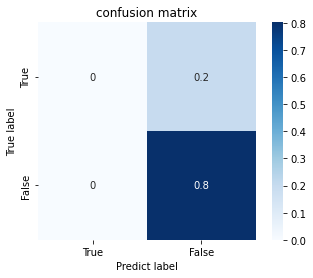

In [21]:
y_base = pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())
show_confusion_matrix(y_test, y_base)

# 様々な機械学習手法の比較

様々な機械学習手法を用いて2値分類を行う。  
簡単に精度を見るため、再現性は担保されていない（引数にrandom_stateを要求しないclfもあるため）ので、必要に応じて再度モデルを構築すること。  
また、パラメータはデフォルト値を使用している。  
そのためパラメータ次第では結果が向上、下降しうる（決定木のf1など）。  

## オーバーサンプリング手法の比較

オーバーサンプリング手法を比較する。  
モデルはデフォルトのものを用い、今回のデータセットに適した・あるいは特徴的なオーバーサンプリングがないか探す。  

### オーバーサンプリングライブラリ
1. imblearn(https://imbalanced-learn.org/stable/over_sampling.html)


In [22]:
bcm_names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "Polynomial SVM",
    "RBF SVM",
    "Sigmoid SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    # "Linear Discriminant Analysis", # predictメソッドに対応していない
    "Quadratic Discriminant Analysis",
]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    # LDA(),
    QDA(),
]

In [23]:
import warnings


def compare_bcms(
    X: pd.DataFrame(),
    y: pd.Series(),
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    plot_columns: list = plot_columns_3,
    sort_column_name: str = "f1_test",
    average_time: int = 20,
    test_size: float = 0.25,
    over_sampling_class=None,
    normalization: bool = False,
):
    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    for name, clf, local_seed in zip(
        bcm_names, classifiers, range(average_time)
    ):  # 指定した複数の分類機を順番に呼び出す

        print(name)  # モデル名
        X_cp, y_cp = X.copy(), y.copy()

        X_train, X_test, y_train, y_test = train_test_split(
            X_cp, y_cp, test_size=test_size, random_state=local_seed
        )  # 訓練データ・テストデータの生成

        if normalization:
            # 正規化
            int_columns = [
                # patient
                "LYMPH_NODES_EXAMINED_POSITIVE",
            ]

            float_columns = [
                # patient
                "NPI",
                "AGE_AT_DIAGNOSIS",
                # sample
                "TUMOR_SIZE",
                "TMB_NONSYNONYMOUS",
            ]

            mm = MinMaxScaler()
            mm.fit(X_train[int_columns + float_columns])
            X_train[int_columns + float_columns] = pd.DataFrame(
                mm.transform(X_train[int_columns + float_columns]),
                index=X_train[int_columns + float_columns].index,
                columns=int_columns + float_columns,
            )

            X_test[int_columns + float_columns] = pd.DataFrame(
                mm.transform(X_test[int_columns + float_columns]),
                index=X_test[int_columns + float_columns].index,
                columns=[int_columns + float_columns],
            )

        # オーバーサンプリング（trainのみなので注意）
        if over_sampling_class:
            X_train, y_train = over_sampling_class.fit_resample(X_train, y_train)

        for _ in tqdm(range(average_time)):  # average_time 回繰り返し、指標の平均を見る
            # 訓練のスコア
            clf.fit(X_train, y_train)  # 学習
            y_pred_train = clf.predict(X_train)
            acc_train = accuracy_score(y_train, y_pred_train)
            f1_train = f1_score(y_train, y_pred_train)
            # 　予測値のスコア
            y_pred = clf.predict(X_test)
            acc_test = accuracy_score(y_test, y_pred)  # 正解率（test）の算出
            f1_test = f1_score(y_test, y_pred)
            result.append([name, acc_train, acc_test, f1_train, f1_test])  # 結果の格納
        show_confusion_matrix(y_test, y_pred)
    # 表示設定
    df_result = pd.DataFrame(
        result, columns=["classifier", "acc_train", "acc_test", "f1_train", "f1_test"]
    )
    df_result_mean = (
        df_result.groupby("classifier")
        .mean()
        .sort_values(sort_column_name, ascending=False)
    )
    warnings.filterwarnings("always")
    return df_result_mean

/var/folders/jt/x8hyslhx72l01gmb45h2dmm40000gn/T/ipykernel_4141/1015810119.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


In [24]:
import warnings


def plot_bcm_border(
    X: pd.DataFrame(),
    y: pd.Series(),
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    plot_columns: list = plot_columns_3,
    sort_column_name: str = "f1_test",
    over_sampling_class=None,
    normalization: bool = False,
    save_path: str = ".",
):

    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    for name, clf in tqdm(zip(bcm_names, classifiers)):  # 指定した複数の分類機を順番に呼び出す
        # init
        X_cp, y_cp = X.copy(), y.copy()

        if normalization:
            # 正規化
            int_columns = [
                # patient
                "LYMPH_NODES_EXAMINED_POSITIVE",
            ]

            float_columns = [
                # patient
                "NPI",
                "AGE_AT_DIAGNOSIS",
                # sample
                "TUMOR_SIZE",
                "TMB_NONSYNONYMOUS",
            ]

            mm = MinMaxScaler()
            mm.fit(X_cp[int_columns + float_columns])
            X_cp[int_columns + float_columns] = pd.DataFrame(
                mm.transform(X_cp[int_columns + float_columns]),
                index=X_cp[int_columns + float_columns].index,
                columns=int_columns + float_columns,
            )
        if over_sampling_class:
            X_cp, y_cp = over_sampling_class.fit_resample(X_cp, y_cp)

        # プロット
        print(name)  # モデル名
        make_dir(save_path)
        sns_separator_plot(
            clf=clf,
            x_columns=plot_columns,
            y_column="target_OS_5years",
            data=pd.merge(X_cp, y_cp, left_index=True, right_index=True),
            save_path=save_path + "/" + name + ".png",
        )
    warnings.filterwarnings("always")

/var/folders/jt/x8hyslhx72l01gmb45h2dmm40000gn/T/ipykernel_4141/4232483305.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


Logistic Regression


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.69it/s]


Nearest Neighbors


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.75it/s]


Linear SVM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.91it/s]


Polynomial SVM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.66it/s]


RBF SVM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.39it/s]


Sigmoid SVM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 62.56it/s]


Decision Tree


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 255.11it/s]


Random Forest


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.08it/s]


AdaBoost


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.07it/s]


Naive Bayes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 364.62it/s]


Quadratic Discriminant Analysis


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 108.58it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.924307,0.936102,0.802228,0.868421
Linear SVM,0.943497,0.942492,0.850704,0.852459
Polynomial SVM,0.902985,0.929712,0.790805,0.830769
Sigmoid SVM,0.900853,0.926518,0.730435,0.818898
Random Forest,1.000000,0.924888,1.000000,0.806887
Decision Tree,1.000000,0.922907,1.000000,0.794164
Logistic Regression,0.947761,0.932907,0.870712,0.792079
AdaBoost,0.972281,0.916933,0.925287,0.779661
Nearest Neighbors,0.945629,0.910543,0.866841,0.750000


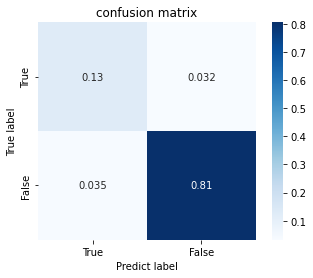

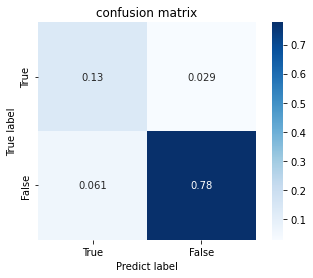

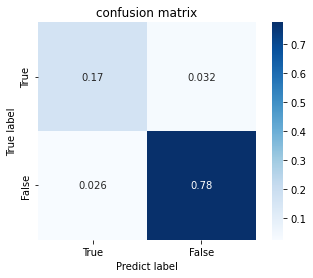

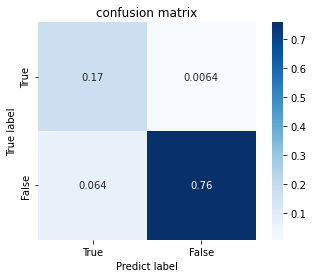

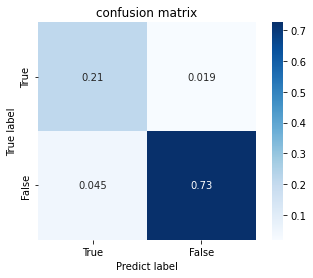

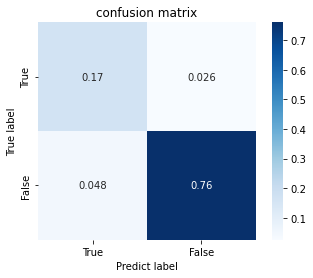

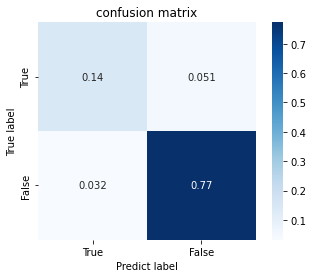

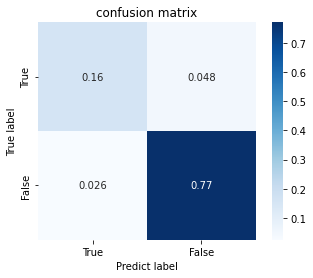

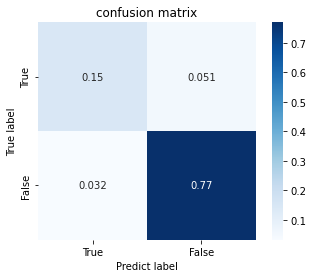

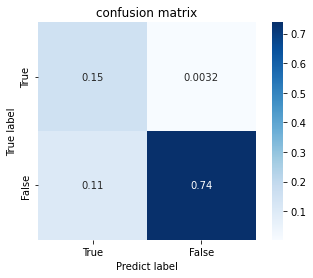

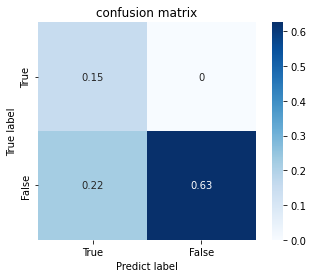

In [25]:
compare_bcms(
    X=X,
    y=y,
    average_time=100,
    plot_columns=plot_columns_3,
)

1it [00:00,  7.68it/s]

Logistic Regression
cv_number=0/10
Nearest Neighbors
cv_number=0/10


2it [00:02,  1.31s/it]

Linear SVM
cv_number=0/10


3it [00:03,  1.27s/it]

Polynomial SVM
cv_number=0/10


4it [00:05,  1.43s/it]

RBF SVM
cv_number=0/10


5it [00:09,  2.54s/it]

Sigmoid SVM
cv_number=0/10


7it [00:11,  1.62s/it]

Decision Tree
cv_number=0/10
Random Forest
cv_number=0/10


8it [00:12,  1.37s/it]

AdaBoost
cv_number=0/10


10it [00:13,  1.23it/s]

Naive Bayes
cv_number=0/10
Quadratic Discriminant Analysis
cv_number=0/10


11it [00:13,  1.22s/it]


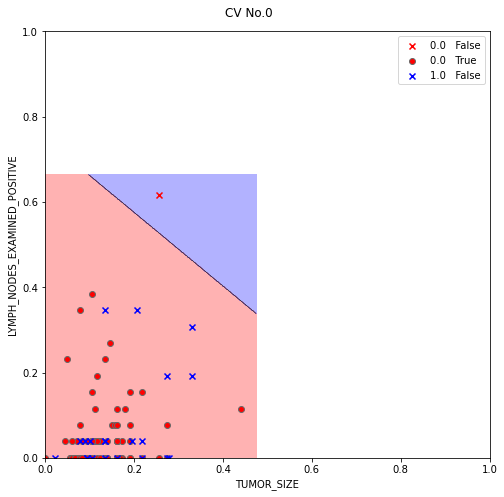

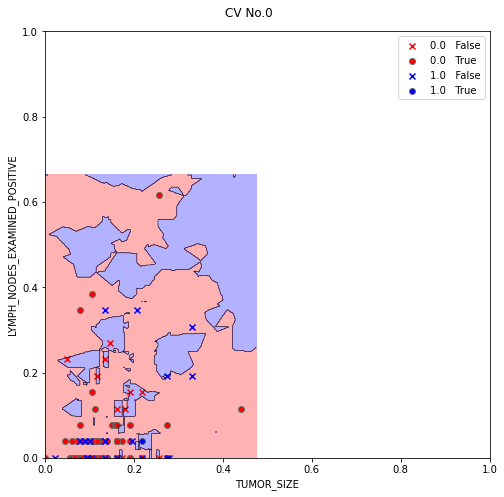

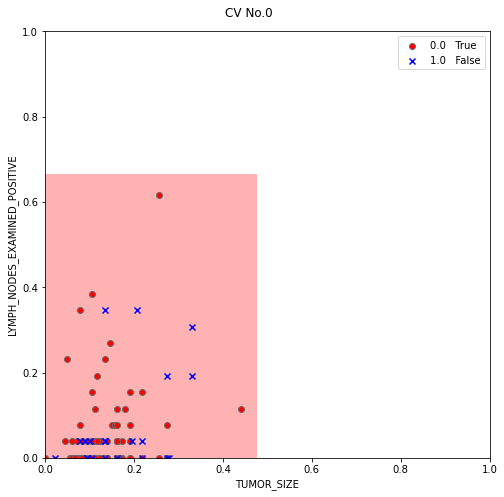

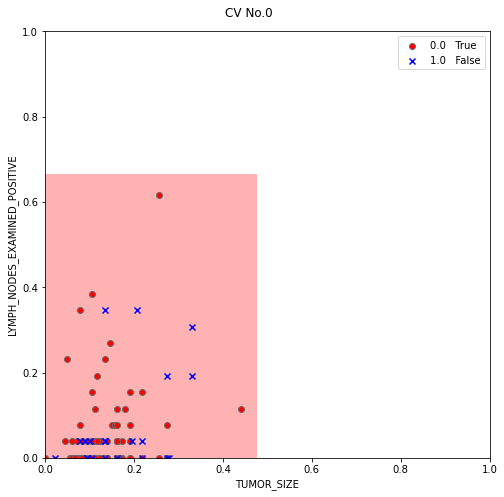

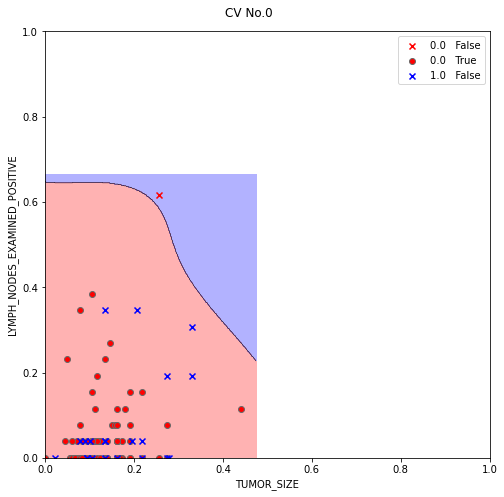

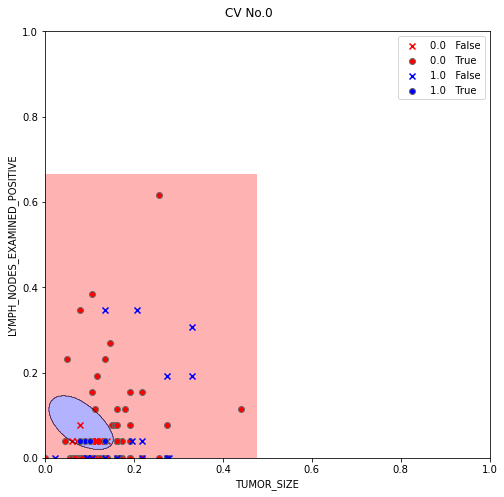

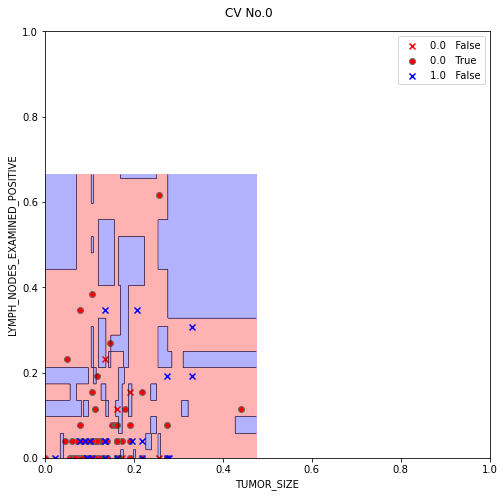

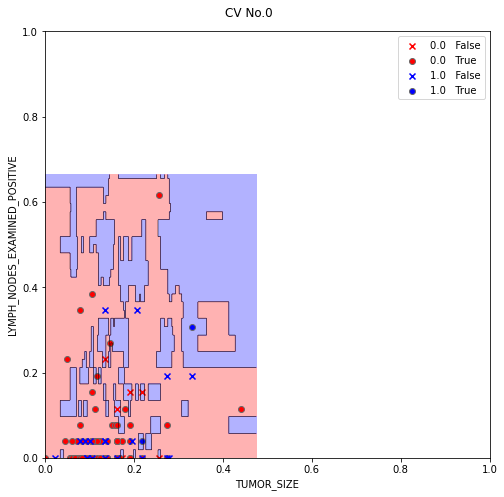

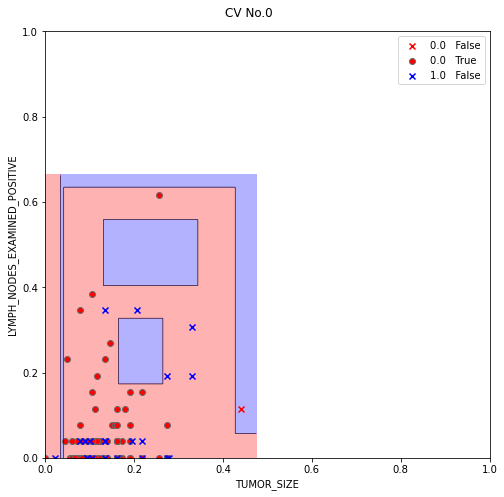

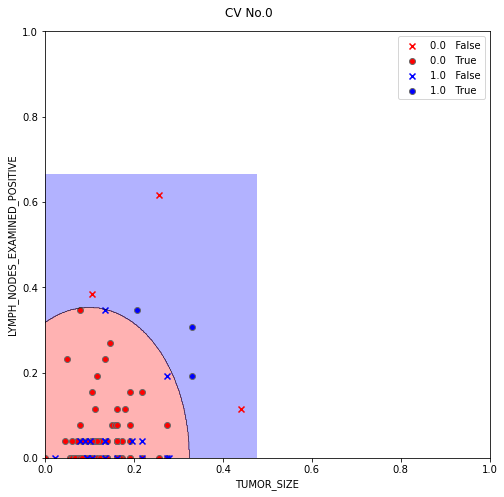

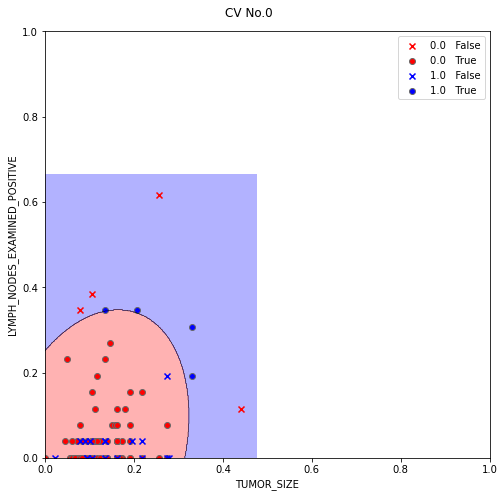

In [26]:
# plot側の内部処理でk分割交差検証を実施するので、trainとtestを結合したデータを渡す。
# ※各モデルのなんとなくの分類結果を見たい。どちらにせよ説明変数2つしか使わないので。
plot_bcm_border(X=X, y=y, save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_BASIC_DIR)

Logistic Regression


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.61it/s]


Nearest Neighbors


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.15it/s]


Linear SVM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.35it/s]


Polynomial SVM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.83it/s]


RBF SVM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.96it/s]


Sigmoid SVM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.00it/s]


Decision Tree


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 107.12it/s]


Random Forest


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.82it/s]


AdaBoost


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.03it/s]


Naive Bayes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 259.20it/s]


Quadratic Discriminant Analysis


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.22it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Linear SVM,0.956863,0.948882,0.957801,0.875000
RBF SVM,0.943871,0.926518,0.946462,0.862275
Polynomial SVM,0.940053,0.929712,0.943302,0.835821
AdaBoost,0.973203,0.923323,0.973497,0.823529
Decision Tree,1.000000,0.929776,1.000000,0.816346
Random Forest,0.999993,0.920447,0.999993,0.813253
Nearest Neighbors,0.955570,0.920128,0.957352,0.800000
Logistic Regression,0.958831,0.907348,0.959530,0.752137
Naive Bayes,0.916888,0.881789,0.920128,0.708661


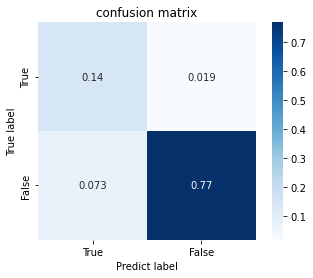

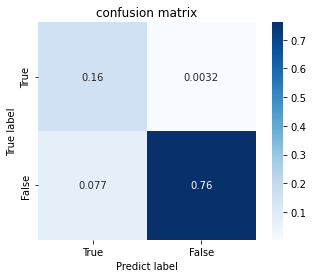

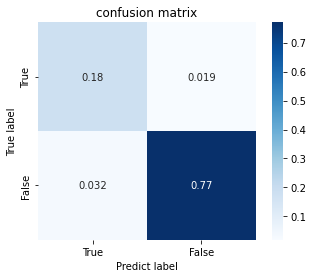

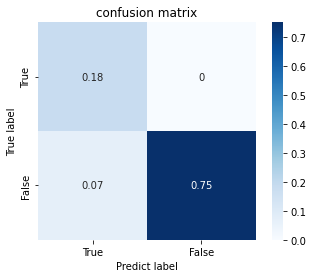

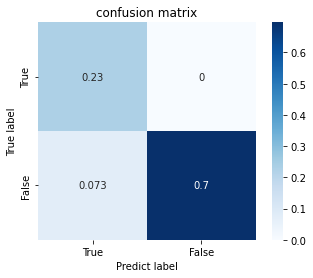

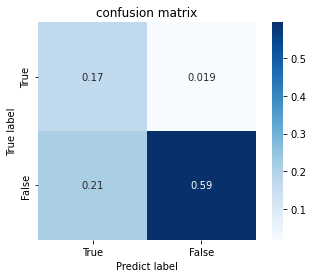

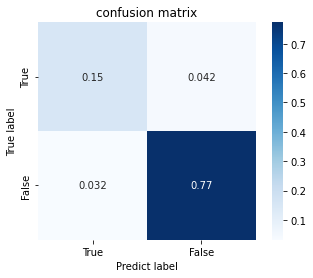

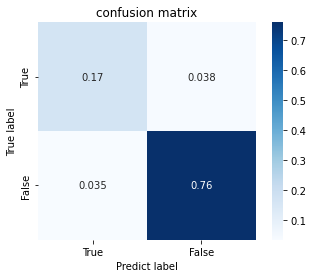

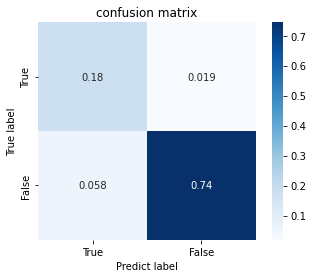

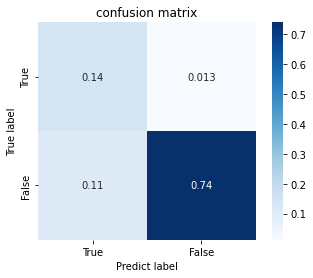

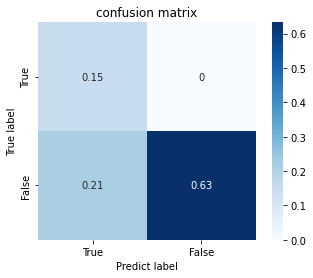

In [27]:
compare_bcms(
    X=X,
    y=y,
    average_time=100,
    over_sampling_class=SMOTE(random_state=SEED),
    plot_columns=plot_columns_3,
)

1it [00:00,  7.41it/s]

Logistic Regression
cv_number=0/10
Nearest Neighbors
cv_number=0/10


2it [00:02,  1.41s/it]

Linear SVM
cv_number=0/10


3it [00:06,  2.71s/it]

Polynomial SVM
cv_number=0/10


4it [00:11,  3.68s/it]

RBF SVM
cv_number=0/10


5it [00:24,  6.82s/it]

Sigmoid SVM
cv_number=0/10


7it [00:29,  4.25s/it]

Decision Tree
cv_number=0/10
Random Forest
cv_number=0/10


8it [00:30,  3.21s/it]

AdaBoost
cv_number=0/10


10it [00:31,  1.71s/it]

Naive Bayes
cv_number=0/10
Quadratic Discriminant Analysis
cv_number=0/10


11it [00:31,  2.86s/it]


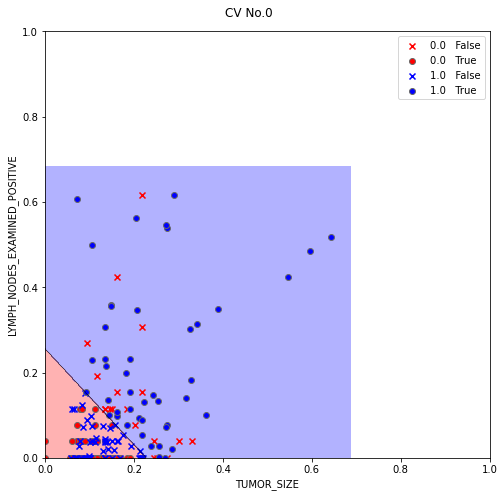

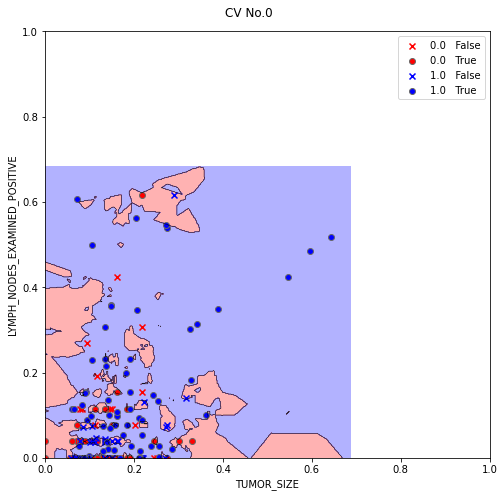

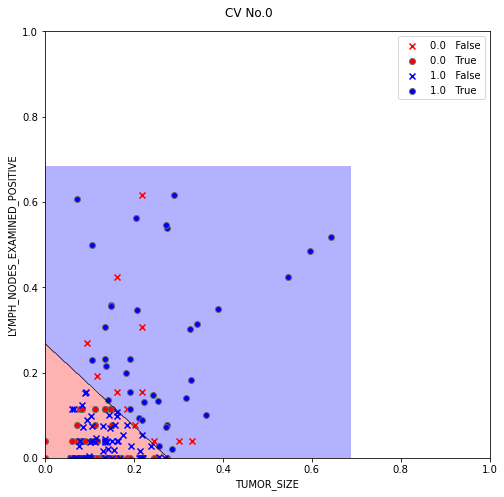

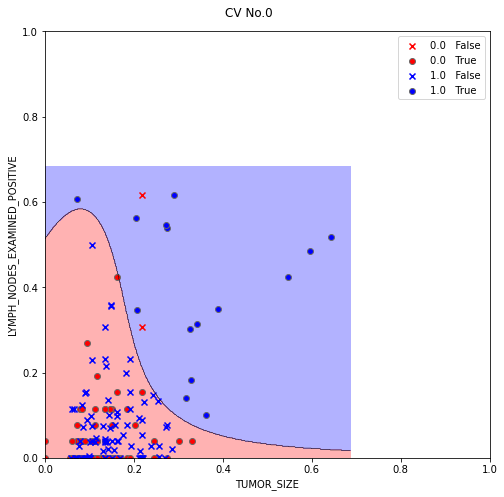

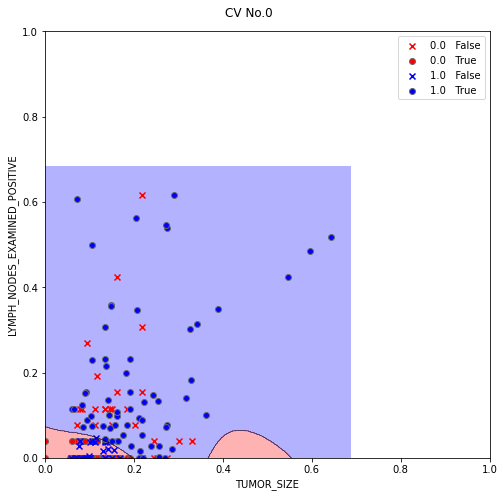

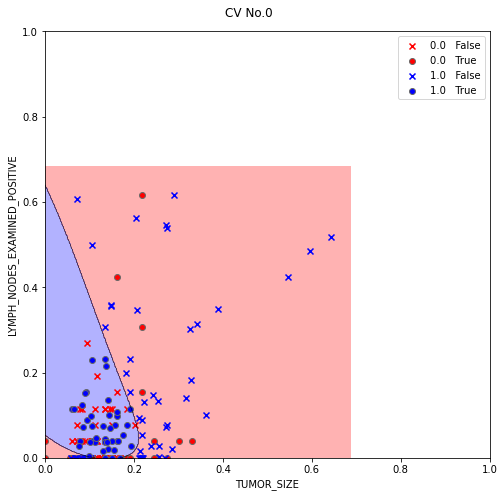

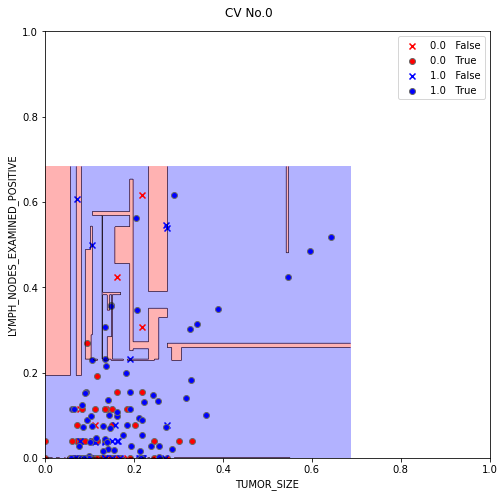

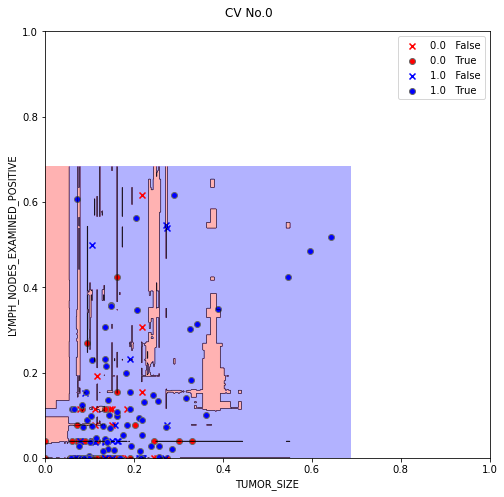

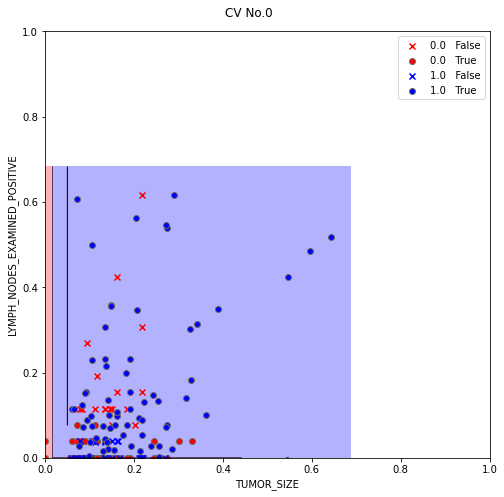

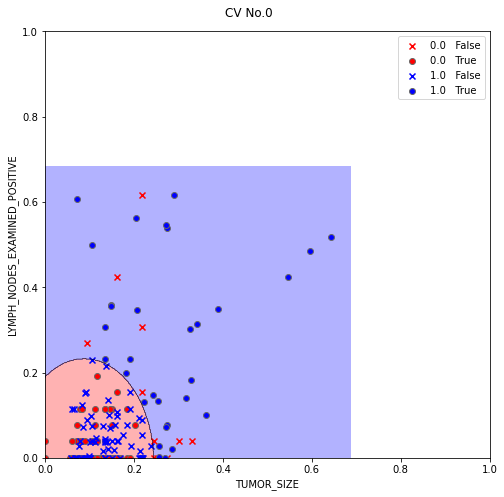

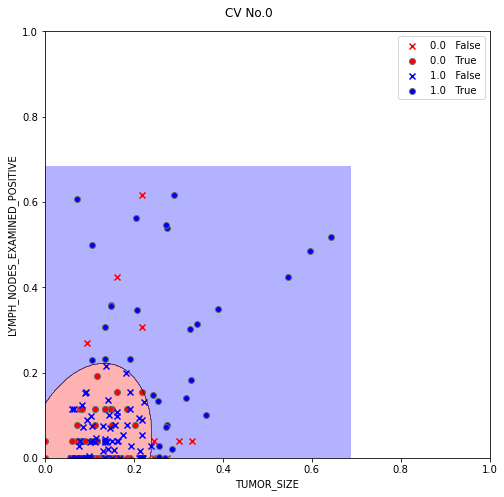

In [28]:
plot_bcm_border(
    X=X,
    y=y,
    over_sampling_class=SMOTE(random_state=SEED),
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_OVERSAMPLING_SMOTE_DIR,
)

Logistic Regression


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.19it/s]


Nearest Neighbors


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.39it/s]


Linear SVM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.16it/s]


Polynomial SVM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.80it/s]


RBF SVM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.78it/s]


Sigmoid SVM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.05it/s]


Decision Tree


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 111.72it/s]


Random Forest


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.37it/s]


AdaBoost


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.76it/s]


Naive Bayes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 287.23it/s]


Quadratic Discriminant Analysis


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.93it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Linear SVM,0.952288,0.955272,0.953651,0.890625
RBF SVM,0.945161,0.926518,0.948012,0.862275
Polynomial SVM,0.938735,0.926518,0.942272,0.829630
Random Forest,1.000000,0.920351,1.000000,0.813115
Nearest Neighbors,0.960212,0.923323,0.961735,0.803279
AdaBoost,0.977124,0.916933,0.977346,0.803030
Logistic Regression,0.958167,0.916933,0.959117,0.783333
Decision Tree,1.000000,0.907987,1.000000,0.752032
Naive Bayes,0.899601,0.884984,0.901884,0.714286


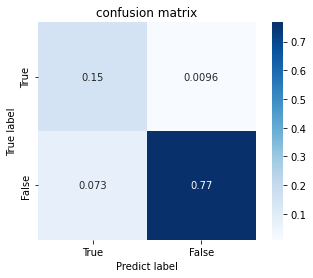

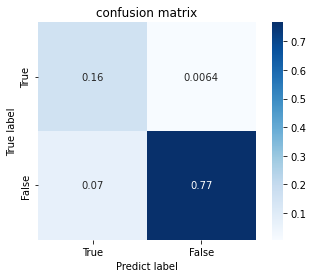

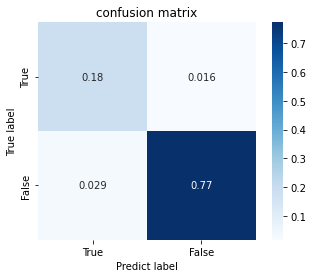

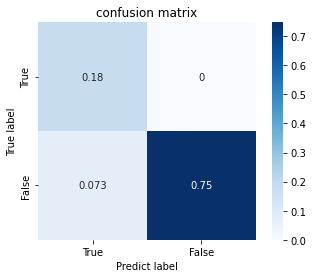

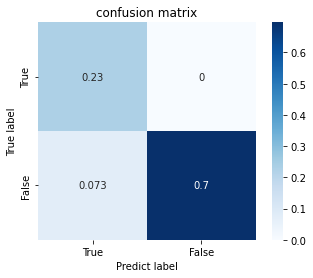

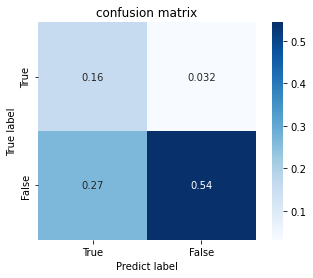

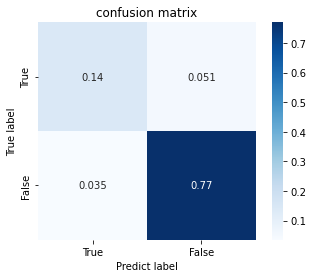

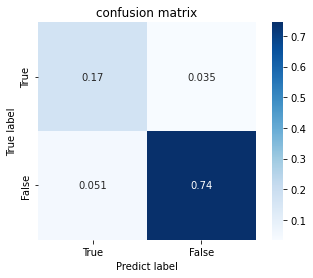

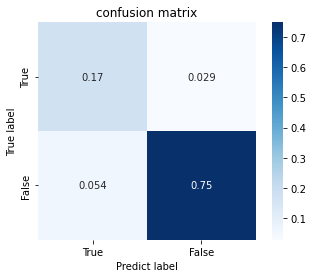

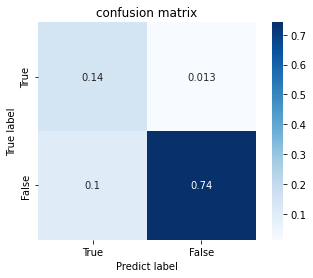

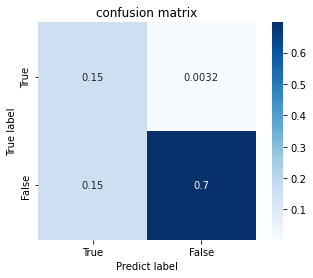

In [29]:
compare_bcms(
    X=X,
    y=y,
    average_time=100,
    over_sampling_class=SMOTE(random_state=SEED),
    plot_columns=plot_columns_3,
    normalization=True,
)

1it [00:00,  6.72it/s]

Logistic Regression
cv_number=0/10
Nearest Neighbors
cv_number=0/10


2it [00:02,  1.47s/it]

Linear SVM
cv_number=0/10


3it [00:07,  2.84s/it]

Polynomial SVM
cv_number=0/10


4it [00:12,  3.82s/it]

RBF SVM
cv_number=0/10


5it [00:24,  6.83s/it]

Sigmoid SVM
cv_number=0/10


7it [00:29,  4.25s/it]

Decision Tree
cv_number=0/10
Random Forest
cv_number=0/10


8it [00:30,  3.22s/it]

AdaBoost
cv_number=0/10


10it [00:31,  1.72s/it]

Naive Bayes
cv_number=0/10
Quadratic Discriminant Analysis
cv_number=0/10


11it [00:31,  2.89s/it]


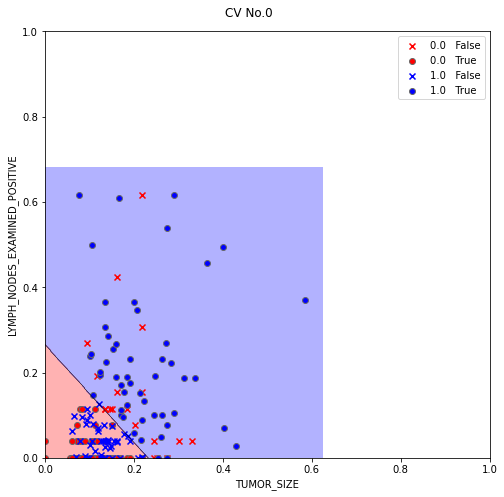

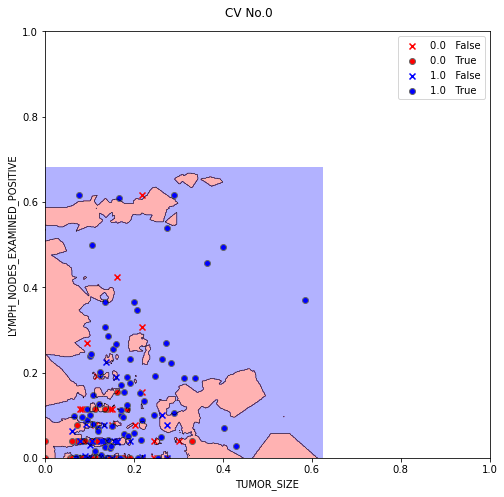

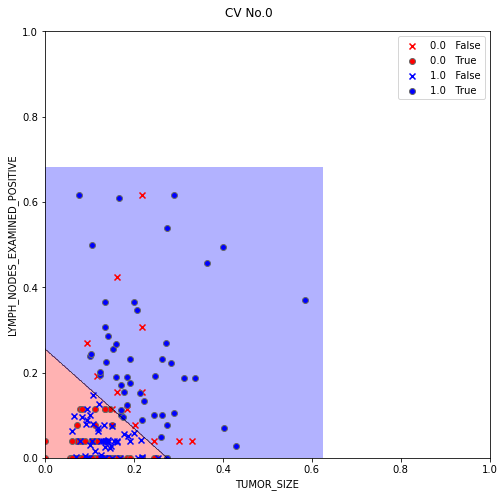

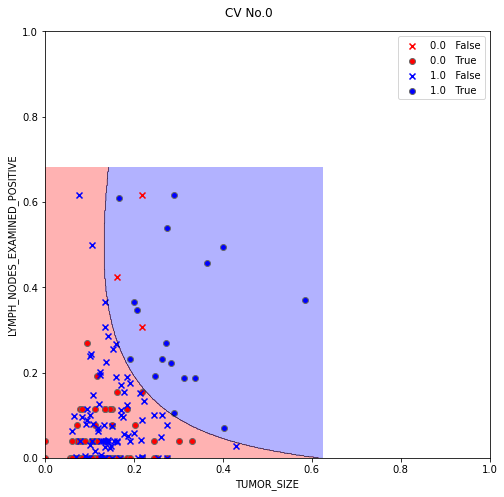

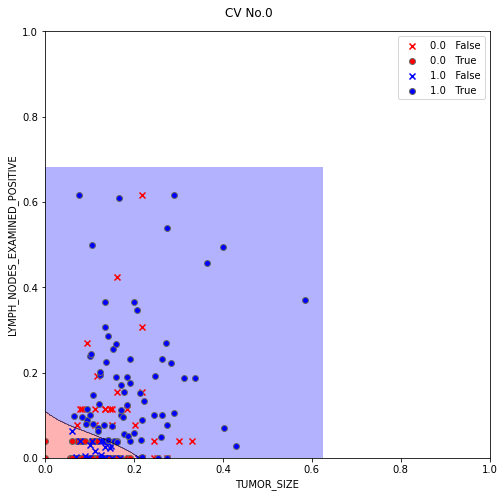

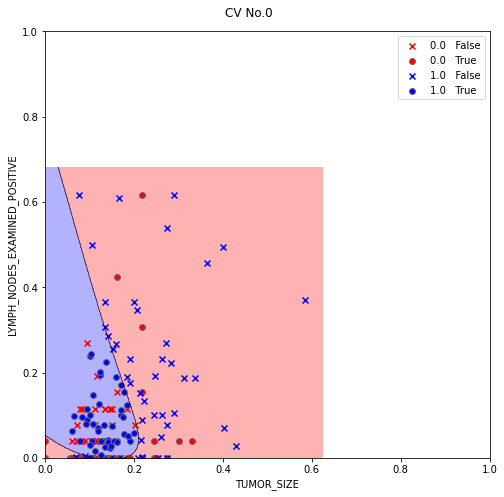

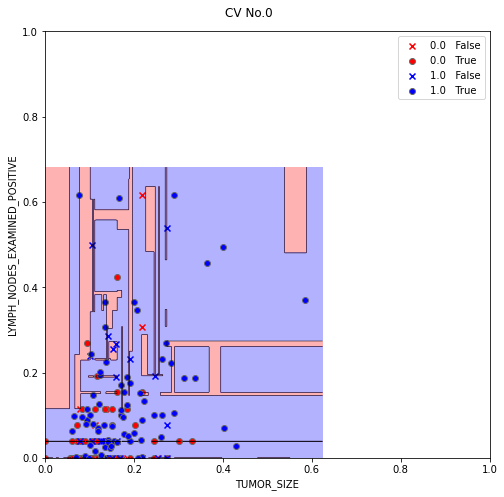

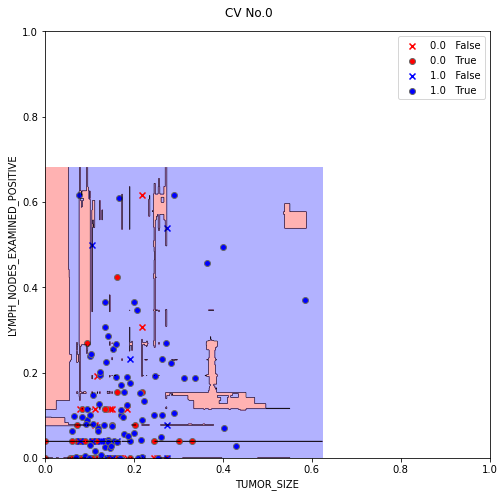

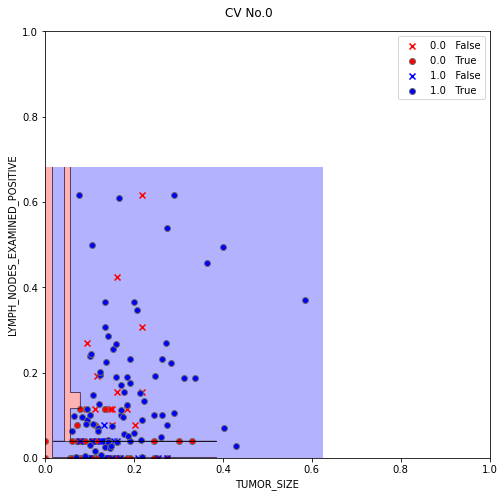

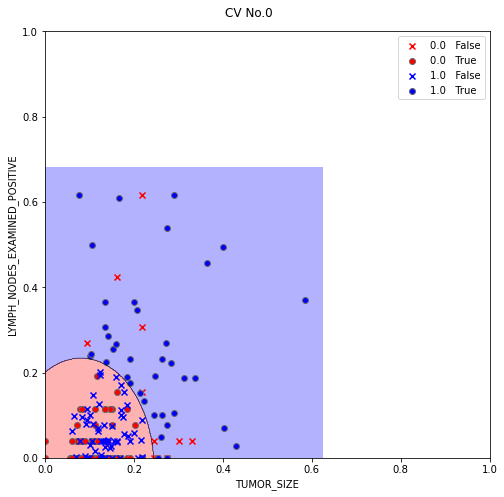

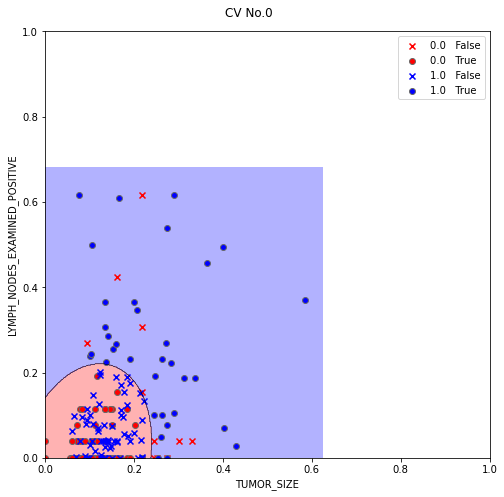

In [30]:
plot_bcm_border(
    X=X,
    y=y,
    over_sampling_class=SMOTE(random_state=SEED),
    normalization=True,
    save_path=config.FIGURES_PROGNOSIS_SURVIVED_BCM_NORMALIZATION_DIR,
)

## 決定木モデルの構築・検証

決定木モデルを構築し、検証していく。  
パラメータを操作するため、forループで回し、最もスコアの高いものを見ていく。

In [31]:
"""import warnings

warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示

accuracies_tree = {}
precisions_tree = {}
recalls_tree = {}
f1_scores_tree = {}

for nodes_num in range(2, 50):
    clf_tree = DecisionTreeClassifier(
        max_leaf_nodes=nodes_num, random_state=config.SEED
    )
    clf_tree = clf_tree.fit(X_resampled, y_resampled)

    y_pred_tree = clf_tree.predict(X_test)

    accuracies_tree[nodes_num] = accuracy_score(y_test, y_pred_tree)
    precisions_tree[nodes_num] = precision_score(y_test, y_pred_tree)
    recalls_tree[nodes_num] = recall_score(y_test, y_pred_tree)
    f1_scores_tree[nodes_num] = f1_score(y_test, y_pred_tree)

    print("nodes_num: ", nodes_num)
    show_scores(y_test, y_pred_tree)
    print("----------" * 10)

warnings.filterwarnings("always")"""

'import warnings\n\nwarnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示\n\naccuracies_tree = {}\nprecisions_tree = {}\nrecalls_tree = {}\nf1_scores_tree = {}\n\nfor nodes_num in range(2, 50):\n    clf_tree = DecisionTreeClassifier(\n        max_leaf_nodes=nodes_num, random_state=config.SEED\n    )\n    clf_tree = clf_tree.fit(X_resampled, y_resampled)\n\n    y_pred_tree = clf_tree.predict(X_test)\n\n    accuracies_tree[nodes_num] = accuracy_score(y_test, y_pred_tree)\n    precisions_tree[nodes_num] = precision_score(y_test, y_pred_tree)\n    recalls_tree[nodes_num] = recall_score(y_test, y_pred_tree)\n    f1_scores_tree[nodes_num] = f1_score(y_test, y_pred_tree)\n\n    print("nodes_num: ", nodes_num)\n    show_scores(y_test, y_pred_tree)\n    print("----------" * 10)\n\nwarnings.filterwarnings("always")'

In [65]:
# compare_bcms()

In [66]:
"""# 各スコアのプロット
display(
    "max nodes_num",
    max(accuracies_tree, key=accuracies_tree.get),
    max(precisions_tree, key=precisions_tree.get),
    max(recalls_tree, key=recalls_tree.get),
    max(f1_scores_tree, key=f1_scores_tree.get),
)

# f1_scoreが最も高いモデルのスコア
print(
    "accuracy: ",
    accuracies_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "precision: ",
    precisions_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "recall: ",
    recalls_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "f1_score: ",
    f1_scores_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)

df_score_tree = pd.DataFrame(
    [accuracies_tree, precisions_tree, recalls_tree, f1_scores_tree],
    index=["accuracy", "precision", "recall", "f1 score"],
    columns=accuracies_tree.keys(),
).T
p = sns.lineplot(data=df_score_tree)
p.set_xlabel("nodes_nums", fontsize=20)
p.set_ylabel("score", fontsize=20)"""

'# 各スコアのプロット\ndisplay(\n    "max nodes_num",\n    max(accuracies_tree, key=accuracies_tree.get),\n    max(precisions_tree, key=precisions_tree.get),\n    max(recalls_tree, key=recalls_tree.get),\n    max(f1_scores_tree, key=f1_scores_tree.get),\n)\n\n# f1_scoreが最も高いモデルのスコア\nprint(\n    "accuracy: ",\n    accuracies_tree[max(f1_scores_tree, key=f1_scores_tree.get)],\n)\nprint(\n    "precision: ",\n    precisions_tree[max(f1_scores_tree, key=f1_scores_tree.get)],\n)\nprint(\n    "recall: ",\n    recalls_tree[max(f1_scores_tree, key=f1_scores_tree.get)],\n)\nprint(\n    "f1_score: ",\n    f1_scores_tree[max(f1_scores_tree, key=f1_scores_tree.get)],\n)\n\ndf_score_tree = pd.DataFrame(\n    [accuracies_tree, precisions_tree, recalls_tree, f1_scores_tree],\n    index=["accuracy", "precision", "recall", "f1 score"],\n    columns=accuracies_tree.keys(),\n).T\np = sns.lineplot(data=df_score_tree)\np.set_xlabel("nodes_nums", fontsize=20)\np.set_ylabel("score", fontsize=20)'

In [67]:
"""clf_tree = DecisionTreeClassifier(
    max_leaf_nodes=max(f1_scores_tree, key=f1_scores_tree.get),
    random_state=config.SEED,
)
clf_tree = clf_tree.fit(X_resampled, y_resampled)
y_pred_tree = clf_tree.predict(X_test)
show_confusion_matrix(y_test, y_pred_tree)"""

'clf_tree = DecisionTreeClassifier(\n    max_leaf_nodes=max(f1_scores_tree, key=f1_scores_tree.get),\n    random_state=config.SEED,\n)\nclf_tree = clf_tree.fit(X_resampled, y_resampled)\ny_pred_tree = clf_tree.predict(X_test)\nshow_confusion_matrix(y_test, y_pred_tree)'